In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
df = pd.read_csv('../data/lab11/Dataset 11000 Reviews.tsv', sep='\t', header=None)
df.columns = ['label', 'text']

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   11000 non-null  object
 1   text    11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [91]:
df.label.value_counts()

label
pos    5699
neg    5300
          1
Name: count, dtype: int64

In [92]:
import re
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df = df[df['label'] != 0]

special_char_rgx = re.compile(r'[^a-zA-Z\s]')
space_rgx = re.compile(r'\s+')
url_rgx = re.compile(r'http\S+|www\S+')

def clean_text(s: str) -> str:
  for rgx, rep in [(special_char_rgx, ''), (space_rgx, ' '), (url_rgx, '')]:
    s = rgx.sub(rep, s)

  return s.lower().strip()

df['text'] = df['text'].apply(clean_text)

df.head()

,label,text
0,1,ab achanak khawaja saad rafique ko khiyaal aag...
1,1,adha drama to censor hi hojaye gaa khaas tor p...
2,1,bekaar fuzool end moti budhi laila jeet gayee ...
3,1,choor kasuri choor jhootay ka moo kaala
4,1,gali gali mein shor hai gaaanjaaaa shair chor hai


In [98]:
class NaiveBayes:
  def _gaussian(self, x, mean, var):
    epsilon = 1e-9
    numerator = np.exp(-0.5 * ((x - mean) ** 2 / (var + epsilon)))
    denominator = np.sqrt(2 * np.pi * (var + epsilon))
    return numerator / denominator
  
  def _get_class_proba(self, x):
    posteriors = []
    for idx, c in enumerate(self._classes):
      mean = self._mean[idx]
      var = self._variance[idx]
      prior = np.log(self._priors[idx])
      # Add small epsilon to avoid log(0)
      posteriors.append(prior + np.sum(np.log(self._gaussian(x, mean, var) + 1e-9)))
    
    return self._classes[np.argmax(posteriors)]

  def fit(self, X, y):
    if hasattr(X, 'toarray'):
      X = X.toarray()
    
    self.n_samples, self.n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)
    
    self._mean = np.zeros((n_classes, self.n_features))
    self._variance = np.zeros((n_classes, self.n_features))
    self._priors = np.zeros(n_classes)

    for idx, c in enumerate(self._classes):
      X_c = X[y == c]
      self._mean[idx, :] = np.mean(X_c, axis=0)
      self._variance[idx, :] = np.var(X_c, axis=0)
      self._priors[idx] = len(X_c) / self.n_samples

  def predict(self, X):
    if hasattr(X, 'toarray'):
      X = X.toarray()
    
    y_hat = [self._get_class_proba(x) for x in X]
    return np.array(y_hat)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['label']

tfidf = TfidfVectorizer(max_features=2000)
X_vec = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, shuffle=True, random_state=42)

nb = NaiveBayes()
nb.fit(X_train, y_train)

c:\Users\Dell\Desktop\sem-repos\mlFall25\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dell\Desktop\sem-repos\mlFall25\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Dell\Desktop\sem-repos\mlFall25\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

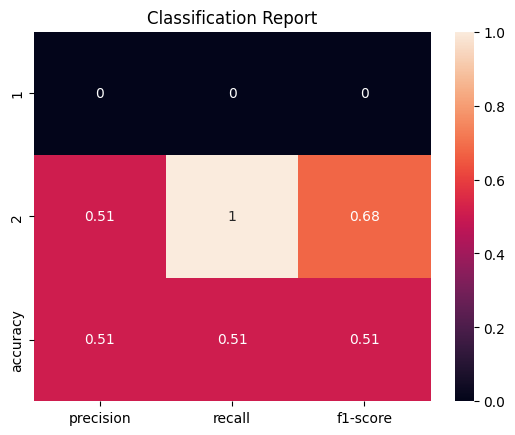

In [106]:
from sklearn.metrics import classification_report

y_pred = nb.predict(X_test)

sns.heatmap(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).iloc[0:3, 0:3].T, annot=True)
plt.title("Classification Report")
plt.show()